In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import skimage
from skimage import io
#from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.color import *
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import plot_model
#import segmentation_models as sm

In [3]:
#memanggil data yang telah disimpan dalam numpy array
all_images = np.load('D:/TugasAkhir/DataSet/NPY File/all_data_images_overlap_0.5.npz')['arr_0']
all_labels = np.load('D:/TugasAkhir/DataSet/NPY File/all_data_labels_overlap_0.5.npz')['arr_0']
all_masks = np.load('D:/TugasAkhir/DataSet/NPY File/all_data_masks_overlap_0.5.npz')['arr_0']

In [4]:
print(all_images.shape)
print(all_masks.shape)
print(all_labels.shape)

(5839, 256, 256, 3)
(5839, 256, 256, 4)
(5839, 256, 256, 1)


In [ ]:
np.unique(all_images)

In [14]:
np.unique(all_masks)

array([  0,   3,  11,  15,  19,  27,  31,  35,  47,  55,  59,  63,  83,
        95,  99, 103, 111, 115, 119, 135, 139, 143, 151, 155, 159, 171,
       191, 195, 199, 207, 219, 223, 227, 235, 239, 243, 251, 255],
      dtype=uint8)

In [15]:
np.unique(all_labels)

array([0., 1., 2., 3., 4.])

### Ubah ke Categorical

In [5]:
all_cats = to_categorical(all_labels, num_classes=5)

In [6]:
all_cats.shape

(5839, 256, 256, 5)

Class yang ada dalam Cell:  [0. 1. 2.]


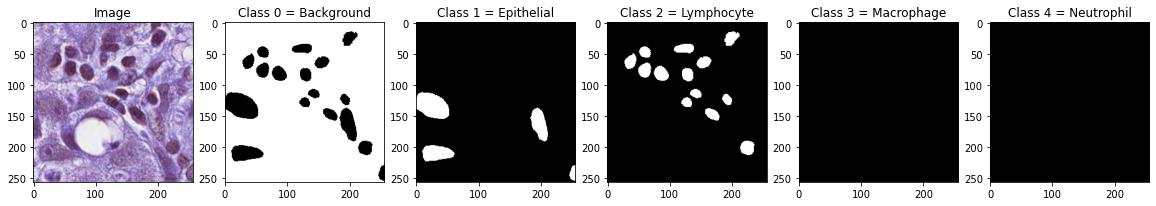

In [7]:
cek_ind=0
plt.figure(figsize=(20,4))
plt.subplot(1,6,1)
plt.imshow(all_images[cek_ind]);
plt.title('Image')
plt.subplot(1,6,2)
plt.imshow(all_cats[cek_ind][:,:,0], cmap='gray');
plt.title('Class 0 = Background')
plt.subplot(1,6,3)
plt.imshow(all_cats[cek_ind][:,:,1], cmap='gray');
plt.title('Class 1 = Epithelial')
plt.subplot(1,6,4)
plt.imshow(all_cats[cek_ind][:,:,2], cmap='gray');
plt.title('Class 2 = Lymphocyte')
plt.subplot(1,6,5)
plt.imshow(all_cats[cek_ind][:,:,3], cmap='gray');
plt.title('Class 3 = Macrophage')
plt.subplot(1,6,6)
plt.imshow(all_cats[cek_ind][:,:,4], cmap='gray');
plt.title('Class 4 = Neutrophil')

print("Class yang ada dalam Cell: ", np.unique(all_labels[cek_ind]))


In [ ]:
all_cats[cek_ind][:,:,4]

### Prepare Training, Validation Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_cats, test_size=0.2, random_state=0)

In [8]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [9]:
print("Data latih: ", X_train.shape)
print("Data validasi: ", X_val.shape)
print("Data uji: ", X_test.shape)

print("Label data latih:", y_train.shape)
print("Label data validasi:", y_val.shape)
print("Label data uji:", y_test.shape)

Data latih:  (4671, 256, 256, 3)
Data validasi:  (584, 256, 256, 3)
Data uji:  (584, 256, 256, 3)
Label data latih: (4671, 256, 256, 5)
Label data validasi: (584, 256, 256, 5)
Label data uji: (584, 256, 256, 5)


In [11]:
np.unique(X_train)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [13]:
np.unique(y_train)

array([0., 1.], dtype=float32)

### Function

In [ ]:
def IoU_patch(y_test,predict):
    class0 = np.sum(np.logical_and(y_test[:,:,0],predict[:,:,0]))/(np.sum(np.logical_or(y_test[:,:,0],predict[:,:,0])))
    class1 = np.sum(np.logical_and(y_test[:,:,1],predict[:,:,1]))/(np.sum(np.logical_or(y_test[:,:,1],predict[:,:,1])))
    class2 = np.sum(np.logical_and(y_test[:,:,2],predict[:,:,2]))/(np.sum(np.logical_or(y_test[:,:,2],predict[:,:,2])))
    class3 = np.sum(np.logical_and(y_test[:,:,3],predict[:,:,3]))/(np.sum(np.logical_or(y_test[:,:,3],predict[:,:,3])))
    class4 = np.sum(np.logical_and(y_test[:,:,4],predict[:,:,4]))/(np.sum(np.logical_or(y_test[:,:,4],predict[:,:,4])))
    mean_iou = [class1,class2,class3,class4]
    mean_iou = np.where(np.isnan(mean_iou), 0, mean_iou)
    mean_iou = np.array(mean_iou)
    mean_iou = mean_iou[mean_iou.nonzero()].mean()
    return mean_iou,class0,class1,class2,class3,class4

In [ ]:
def IoU(y_test,predict):
    all_iou=[] ; bg=[] ; epitel=[] ; limfosit=[] ; makrofag=[] ; neutrofil=[]
    for i in range(len(y_test)):   
        mean_iou,class0,class1,class2,class3,class4 = IoU_patch(y_test[i], predict[i])    
        #print("Mean IoU for patch-",i,": ", mean_iou*100)
        #print("IoU for class0 is: ", class0*100)
        #print("IoU for class1 is: ", class1*100)
        #print("IoU for class2 is: ", class2*100)
        #print("IoU for class3 is: ", class3*100)
        #print("IoU for class4 is: ", class4*100)
        all_iou.append(mean_iou)
        bg.append(class0)
        epitel.append(class1)
        limfosit.append(class2)
        makrofag.append(class3)
        neutrofil.append(class4)
    #Rata-rata seluruh patches
    all_iou = np.where(np.isnan(all_iou), 0, all_iou)
    all_iou_patches = np.array(all_iou)
    average_iou = all_iou_patches[all_iou_patches.nonzero()].mean()
    #Rata-rata background dari seluruh patches
    bg_without_nan = np.where(np.isnan(bg), 0, bg)
    bg = np.array(bg_without_nan)
    bg = bg[bg.nonzero()].mean()
    #Rata-rata sel epitel dari seluruh patches
    epitel_without_nan= np.where(np.isnan(epitel), 0, epitel)
    epitel= np.array(epitel_without_nan) 
    epitel= epitel[epitel.nonzero()].mean()
    #Rata-rata sel epitel dari seluruh patches
    limfosit_without_nan = np.where(np.isnan(limfosit), 0, limfosit)
    limfosit = np.array(limfosit_without_nan)
    limfosit = limfosit[limfosit.nonzero()].mean()
    #Rata-rata sel epitel dari seluruh patches
    makrofag_without_nan = np.where(np.isnan(makrofag), 0, makrofag)
    makrofag = np.array(makrofag_without_nan)
    makrofag = makrofag[makrofag.nonzero()].mean()
    #Rata-rata sel epitel dari seluruh patches
    neutrofil_without_nan = np.where(np.isnan(neutrofil), 0, neutrofil)
    neutrofil= np.array(neutrofil_without_nan)
    neutrofil = neutrofil[neutrofil.nonzero()].mean()
    return average_iou,bg,epitel,limfosit,makrofag,neutrofil

In [ ]:
def visualize(test_train,predict):
    # Ground Truth
    plt.figure(figsize=(16,4))
    plt.subplot(1,5,1)
    plt.imshow(test_train[:,:,0], cmap='gray');
    plt.title('Class 0 - Background')

    plt.subplot(1,5,2)
    plt.imshow(test_train[:,:,1], cmap='gray');
    plt.title('Class 1 - Epitel')

    plt.subplot(1,5,3)
    plt.imshow(test_train[:,:,2], cmap='gray');
    plt.title('Class 2 - Limfosit')

    plt.subplot(1,5,4)
    plt.imshow(test_train[:,:,3], cmap='gray');
    plt.title('Class 3 - Makrofag')

    plt.subplot(1,5,5)
    plt.imshow(test_train[:,:,4], cmap='gray');
    plt.title('Class 4 - Neutrofil')

    # Prediction
    plt.figure(figsize=(16,4))
    plt.subplot(1,5,1)
    plt.imshow(predict[:,:,0], cmap='gray');
    plt.title('Class 0 - Background')

    plt.subplot(1,5,2)
    plt.imshow(predict[:,:,1], cmap='gray');
    plt.title('Class 1 - Epitel')

    plt.subplot(1,5,3)
    plt.imshow(predict[:,:,2], cmap='gray');
    plt.title('Class 2 - Limfosit')

    plt.subplot(1,5,4)
    plt.imshow(predict[:,:,3], cmap='gray');
    plt.title('Class 3 - Makrofag')

    plt.subplot(1,5,5)
    plt.imshow(predict[:,:,4], cmap='gray');
    plt.title('Class 4 - Neutrofil')

In [ ]:
eps=1e-5

In [ ]:
# Compute Panoptic quality metric for each image
def Panoptic_quality(ground_truth_image,predicted_image):
    TP = 0
    FP = 0
    FN = 0
    sum_IOU = 0
    matched_instances = {}# Create a dictionary to save ground truth indices in keys and predicted matched instances as velues
                        # It will also save IOU of the matched instance in [indx][1]

    # Find matched instances and save it in a dictionary
    for i in np.unique(ground_truth_image):
        if i == 0:
            pass
        else:
            temp_image = np.array(ground_truth_image)
            temp_image = temp_image == i
            matched_image = temp_image * predicted_image
        
            for j in np.unique(matched_image):
                if j == 0:
                    pass
                else:
                    pred_temp = predicted_image == j
                    intersection = sum(sum(temp_image*pred_temp))
                    union = sum(sum(temp_image + pred_temp))
                    IOU = intersection/union
                    if IOU> 0.5:
                        matched_instances [i] = j, IOU 
                        
    # Compute TP, FP, FN and sum of IOU of the matched instances to compute Panoptic Quality               
                        
    pred_indx_list = np.unique(predicted_image)
    pred_indx_list = np.array(pred_indx_list[1:])

    # Loop on ground truth instances
    for indx in np.unique(ground_truth_image):
        if indx == 0:
            pass
        else:
            if indx in matched_instances.keys():
                pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == [indx][0]))
                TP = TP+1
                sum_IOU = sum_IOU+matched_instances[indx][1]
            else:
                FN = FN+1
    FP = len(np.unique(pred_indx_list))
    PQ = sum_IOU/(TP+0.5*FP+0.5*FN+eps)
    
    return PQ

# Model ResNet34-UNet

In [ ]:
model_resnet34= keras.models.load_model("D:/TugasAkhir/DataSet/h5 file/monusac_unet_filter16_ov5_resnet34.h5")

In [ ]:
plot_model(model_resnet34,show_shapes=True)

In [ ]:
model_resnet34.summary()

In [ ]:
predict_test_resnet34= np.load('D:/TugasAkhir/DataSet/NPY File/unet16_predict_test_ov5_resnet34.npz')['arr_0']

In [ ]:
predict_test_resnet34.shape

In [ ]:
ind_test = random.randint(0, X_test.shape[0]-1)
#ind_test=301
print("Train index =", ind_test)
visualize (y_test[ind_test],predict_test_resnet34[ind_test])

In [ ]:
#coba predict citra diatas
predict_test_argmax_resnet34=np.argmax(predict_test_resnet34[ind_test], axis=2)

In [ ]:
predict_test_argmax_resnet34.shape

In [ ]:
plt.imshow(predict_test_argmax_resnet34, cmap='viridis')

In [ ]:
np.unique(predict_test_argmax_resnet34)

## Model ResNet34-UNet IoU & PQ Metric

In [ ]:
#IoU 
predict_test_argmax_all_resnet34=np.argmax(predict_test_resnet34, axis=3)

In [ ]:
predict_test_argmax_all_resnet34.shape

In [ ]:
predict_test_argmax_allchannel_resnet34=to_categorical(predict_test_argmax_all_resnet34, num_classes=5)

In [ ]:
predict_test_argmax_allchannel_resnet34.shape

In [ ]:
average_iou_resnet34,class0_resnet34,class1_resnet34,class2_resnet34,class3_resnet34,class4_resnet34=IoU(y_test,predict_test_argmax_allchannel_resnet34)

In [ ]:
print("ResNet34 - UNet")
print("Average IoU      : ", average_iou_resnet34)
print("IoU for class0 is: ", class0_resnet34)
print("IoU for class1 is: ", class1_resnet34)
print("IoU for class2 is: ", class2_resnet34)
print("IoU for class3 is: ", class3_resnet34)
print("IoU for class4 is: ", class4_resnet34)

In [ ]:
y_test_all = np.argmax(y_test, axis=3)
print(y_test_all.shape)
print(predict_test_argmax_all_resnet34.shape)

In [ ]:
pq_metric_model_resnet34=[]
for i in range(len(y_test_all)):   
    pq_metric = Panoptic_quality(y_test_all[i], predict_test_argmax_all_resnet34[i])    
    #print(i,pq_metric)
    pq_metric_model_resnet34.append(pq_metric)
pq_metric_model_resnet34 = np.array(pq_metric_model_resnet34) 
pq_metric_resnet34 = pq_metric_model_resnet34[pq_metric_model_resnet34.nonzero()].mean()   
print("Mean PQ : ", pq_metric_resnet34)

# Model VGG16-UNet

In [ ]:
model_vgg16= keras.models.load_model("D:/TugasAkhir/DataSet/h5 file/monusac_unet_filter16_ov5_vgg16.h5")

In [ ]:
plot_model(model_vgg16,show_shapes=True)

In [ ]:
model_vgg16.summary()

In [ ]:
predict_test_vgg16= np.load('D:/TugasAkhir/DataSet/NPY File/unet16_predict_test_ov5_vgg16.npz')['arr_0']

In [ ]:
predict_test_vgg16.shape

In [ ]:
print("Train index =", ind_test)
visualize (y_test[ind_test],predict_test_vgg16[ind_test])

In [ ]:
#coba predict citra diatas
predict_test_argmax_vgg16=np.argmax(predict_test_vgg16[ind_test], axis=2)

In [ ]:
predict_test_argmax_vgg16.shape

In [ ]:
plt.imshow(predict_test_argmax_vgg16, cmap='viridis')

In [ ]:
np.unique(predict_test_argmax_vgg16)

## Model VGG16-UNet IoU & PQ Metric

In [ ]:
#IoU 
predict_test_argmax_all_vgg16=np.argmax(predict_test_vgg16, axis=3)

In [ ]:
predict_test_argmax_all_vgg16.shape

In [ ]:
predict_test_argmax_allchannel_vgg16=to_categorical(predict_test_argmax_all_vgg16, num_classes=5)

In [ ]:
predict_test_argmax_allchannel_vgg16.shape

In [ ]:
average_iou_vgg16,class0_vgg16,class1_vgg16,class2_vgg16,class3_vgg16,class4_vgg16=IoU(y_test,predict_test_argmax_allchannel_vgg16)

In [ ]:
print("VGG16 - UNet")
print("Average IoU      : ", average_iou_vgg16)
print("IoU for class0 is: ", class0_vgg16)
print("IoU for class1 is: ", class1_vgg16)
print("IoU for class2 is: ", class2_vgg16)
print("IoU for class3 is: ", class3_vgg16)
print("IoU for class4 is: ", class4_vgg16)

In [ ]:
print(y_test_all.shape)
print(predict_test_argmax_all_vgg16.shape)

In [ ]:
pq_metric_model_vgg16=[]
for i in range(len(y_test_all)):   
    pq_metric = Panoptic_quality(y_test_all[i], predict_test_argmax_all_vgg16[i])    
    #print(i,pq_metric)
    pq_metric_model_vgg16.append(pq_metric)
pq_metric_model_vgg16 = np.array(pq_metric_model_vgg16) 
pq_metric_vgg16 = pq_metric_model_vgg16[pq_metric_model_vgg16.nonzero()].mean()   
print("Mean PQ : ", pq_metric_vgg16)

# Model inceptionv3-UNet

In [ ]:
model_inceptionv3= keras.models.load_model("D:/TugasAkhir/DataSet/h5 file/monusac_unet_filter16_ov5_inceptionv3.h5")

In [ ]:
plot_model(model_inceptionv3,show_shapes=True)

In [ ]:
model_inceptionv3.summary()

In [ ]:
predict_test_inceptionv3= np.load('D:/TugasAkhir/DataSet/NPY File/unet16_predict_test_ov5_inceptionv3.npz')['arr_0']

In [ ]:
predict_test_inceptionv3.shape

In [ ]:
print("Train index =", ind_test)
visualize (y_test[ind_test],predict_test_inceptionv3[ind_test])

In [ ]:
#coba predict citra diatas
predict_test_argmax_inceptionv3=np.argmax(predict_test_inceptionv3[ind_test], axis=2)

In [ ]:
predict_test_argmax_inceptionv3.shape

In [ ]:
plt.imshow(predict_test_argmax_inceptionv3, cmap='viridis')

In [ ]:
np.unique(predict_test_argmax_inceptionv3)

## Model inceptionv3-UNet IoU & PQ Metric

In [ ]:
#IoU 
predict_test_argmax_all_inceptionv3=np.argmax(predict_test_inceptionv3, axis=3)

In [ ]:
predict_test_argmax_all_inceptionv3.shape

In [ ]:
predict_test_argmax_allchannel_inceptionv3=to_categorical(predict_test_argmax_all_inceptionv3, num_classes=5)

In [ ]:
predict_test_argmax_allchannel_inceptionv3.shape

In [ ]:
average_iou_inc,class0_inc,class1_inc,class2_inc,class3_inc,class4_inc=IoU(y_test,predict_test_argmax_allchannel_inceptionv3)

In [ ]:
print("Inceptionv3 - UNet")
print("Average IoU      : ", average_iou_inc)
print("IoU for class0 is: ", class0_inc)
print("IoU for class1 is: ", class1_inc)
print("IoU for class2 is: ", class2_inc)
print("IoU for class3 is: ", class3_inc)
print("IoU for class4 is: ", class4_inc)

In [ ]:
print(y_test_all.shape)
print(predict_test_argmax_all_inceptionv3.shape)

In [ ]:
pq_metric_model_inceptionv3=[]
for i in range(len(y_test_all)):   
    pq_metric = Panoptic_quality(y_test_all[i], predict_test_argmax_all_inceptionv3[i])    
    #print(i,pq_metric)
    pq_metric_model_inceptionv3.append(pq_metric)
pq_metric_model_inceptionv3 = np.array(pq_metric_model_inceptionv3) 
pq_metric_inceptionv3 = pq_metric_model_inceptionv3[pq_metric_model_inceptionv3.nonzero()].mean()   
print("Mean PQ : ", pq_metric_inceptionv3)